In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functions_anisotropy import *

### Estimate propagation direction of a single incoming wave

author: Sebastian Noe, snoe@geophysik.uni-muenchen.de

$
\ddot u_x = -A\omega^2n_x\exp(i\omega(t-\frac{x\cdot\nu}{v}))
$

$
\ddot u_y = -A\omega^2n_y\exp(i\omega(t-\frac{x\cdot\nu}{v}))
$

$
\ddot u_z = -A\omega^2n_z\exp(i\omega(t-\frac{x\cdot\nu}{v}))
$

$
\dot\Omega_x = -\frac{A\omega^2}{2v}(\nu_yn_z-\nu_zn_y)\exp(i\omega(t-\frac{x\cdot\nu}{v}))
$

$
\dot\Omega_y = -\frac{A\omega^2}{2v}(\nu_zn_x-\nu_xn_z)\exp(i\omega(t-\frac{x\cdot\nu}{v}))
$

$
\dot\Omega_z = -\frac{A\omega^2}{2v}(\nu_xn_y-\nu_yn_x)\exp(i\omega(t-\frac{x\cdot\nu}{v}))
$

$
\dot\epsilon_{zz} = -\frac{A\omega^2}{v}\nu_zn_z\exp(i\omega(t-\frac{x\cdot\nu}{v}))
$




#### Using 7C seismometer

Translational measurements are used to determine the polarization vector $n$.
Ratios of rotational components and the horizontal deformation are formed to extract the propagation direction. These ratios have the advantage of eliminating the unknown phase-velocity $v$.

$
\frac{\dot\Omega_y}{\dot\epsilon_{zz}} = \frac{1}{2}\frac{\nu_zn_x-\nu_xn_z}{\nu_zn_z} = \frac{1}{2}(\frac{n_x}{n_z}-\frac{\nu_x}{\nu_z})
$

$
\frac{\dot\Omega_x}{\dot\epsilon_{zz}} = \frac{1}{2}\frac{\nu_yn_z-\nu_zn_y}{\nu_zn_z} = \frac{1}{2}(\frac{\nu_y}{\nu_z}-\frac{n_y}{n_z})
$

Assuming (before normalization) $\nu_z=1$, we see

$
\nu = \begin{pmatrix}- \frac{2\dot\Omega_y}{\dot\epsilon_{zz}}+ \frac{n_x}{n_z}\\ \frac{2\dot\Omega_x}{\dot\epsilon_{zz}} + \frac{n_y}{n_z}  \\ 1 \end{pmatrix}
$

This works for all wavetypes (qP, qS1, qS2) of all symmetries. Some directions may not be resolvable, including purely horizontal propagating waves or purely horizontal polarized waves. 

The latter is the case for SH-waves in VTI-media. 
The problem is that the polarization is purely horizontal, i.e. the vertical strain is zero. One could try to form ratios between rotational components: 

$\dot\Omega_y / \dot\Omega_x = n_x/n_y$ 

$\dot\Omega_z / \dot\Omega_y = \frac{\nu_x}{\nu_z}\frac{n_y}{n_x}-\frac{\nu_y}{\nu_z}$

$\dot\Omega_z / \dot\Omega_x = \frac{\nu_y}{\nu_x}\frac{n_x}{n_y}-\frac{\nu_x}{\nu_z}$

The first equation doesn't contain any new information and the other two can be transformed to (assuming $\nu_z=1$, before normalization):

$
\begin{pmatrix}\dot\Omega_z / \dot\Omega_y \\ \dot\Omega_z / \dot\Omega_x \end{pmatrix} = \begin{pmatrix} \frac{n_y}{n_x} & -1 \\ -1 & \frac{n_x}{n_y} \end{pmatrix} \begin{pmatrix} \nu_x\\\nu_y \end{pmatrix}
$

The matrix's determinant is 0. Hence, the system cannot be uniquely solved and the propagation direction cannot be determined. 

With the same reasoning, one can show that one needs the seventh-component (vertical strain) in order to determine propagation direction for single wavefronts.

Having the full translational and rotational measurements, one can always find a rotation for the seismometer such that $n_z=0$. The resulting rotational ratios follow above's derivation, leading to the same singular matrix. Not forming ratios is also not an option as the cross-product operator is not invertible.

In [2]:
def get_seis_one_wavetype(mode,v,vel,nu,f):
    
    l1 = np.argmax(vel)
    l3 = np.argmin(vel)
    for i in range(0,3):
        if l1!=i and l3!=i:
            l2 = i
    if mode=='qP':
        vel_0 = vel[l1]
        v_0 = v[:,l1]
    elif mode=='qS1':
        vel_0 = vel[l2]
        v_0 = v[:,l2]
    elif mode=='qS2':
        vel_0 = vel[l3]
        v_0 = v[:,l3]
    
    xr = max(vel)
    tmax = xr / min(vel) * 1.3
    nt = 30000
    t = np.linspace(0,tmax,nt)
    seis = np.zeros((7,nt))   
    A = 1
    omega = 2*np.pi*f
    vel = vel_0
    v = v_0
    
    seis[0,:] = - v[0]*A*omega**2*(t-xr/vel)*np.exp(-(f**2)*(t-xr/vel)**2) 
    seis[1,:] = - v[1]*A*omega**2*(t-xr/vel)*np.exp(-(f**2)*(t-xr/vel)**2)
    seis[2,:] = - v[2]*A*omega**2*(t-xr/vel)*np.exp(-(f**2)*(t-xr/vel)**2)
     
    
    seis[3,:] =- np.cross(nu,v)[0]*A*omega**2/(2*vel)*(t-xr/vel)*np.exp(-(f**2)*(t-xr/vel)**2)
    seis[4,:] =- np.cross(nu,v)[1]*A*omega**2/(2*vel)*(t-xr/vel)*np.exp(-(f**2)*(t-xr/vel)**2)
    seis[5,:] =- np.cross(nu,v)[2]*A*omega**2/(2*vel)*(t-xr/vel)*np.exp(-(f**2)*(t-xr/vel)**2)
    
    seis[6,:] = - A * omega**2/vel*v[2]*nu[2]*(t-xr/vel)*np.exp(-(f**2)*(t-xr/vel)**2) 
    
    return seis, t

In [3]:
def plot_7C(seis,t):
    a1 = abs(seis[0:3][:].max())
    plt.figure(figsize=(8,4))
    plt.title('Translation')
    
    plt.plot(t,seis[0,:],label='x')
    plt.plot(t,seis[1,:]-a1,label='y')
    plt.plot(t,seis[2,:]-2*a1,label='z')
    plt.legend()
    plt.yticks([])
    plt.show()
    a2 = seis[3:6][:].max()
    plt.figure(figsize=(8,4))
    plt.title('Rotation')
    plt.plot(t,seis[3,:],label='rot_x')
    plt.plot(t,seis[4,:]-a2,label='rot_y')
    plt.plot(t,seis[5,:]-2*a2,label='rot_z')
    plt.legend()
    plt.yticks([])
    plt.show()
    
    plt.figure(figsize=(8,4))
    plt.title('Strain')
    plt.plot(t,seis[6,:],color='green',label='strain_zz')
    plt.legend()
    plt.yticks([])
    plt.show()
    

In [4]:
medium = load_medium_list()
print(' ')
random_medium = load_random_medium_list()

#0 isotropic
#1 taylor sandstone
#2 mesaverde clayshale
#3 mesaverde laminated siltstone
#4 mesaverde mudshale
#5 mesaverde calcareous sandstone
#6 quartz
 
#0 isotropic
#1 cubic
#2 VTI
#3 tetragonal
#4 trigonal
#5 orthorhombic
#6 monoclinic
#7 triclinic


In [5]:
index = 7
#C, density = get_specific_VTI(medium[index])
C, density = get_random_C(random_medium[index],30)

triclinic
[[396.456 164.789  65.312 115.318 131.275  56.138]
 [164.789 490.062  93.465  61.685 111.25   78.295]
 [ 65.312  93.465 459.354  89.106 151.387 119.108]
 [115.318  61.685  89.106 402.324  81.021  71.139]
 [131.275 111.25  151.387  81.021 422.178  75.995]
 [ 56.138  78.295 119.108  71.139  75.995 231.162]]


C:\Users\sebi\Downloads\Master-notebooks\functions_anisotropy.py:455: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111, projection='stereonet')


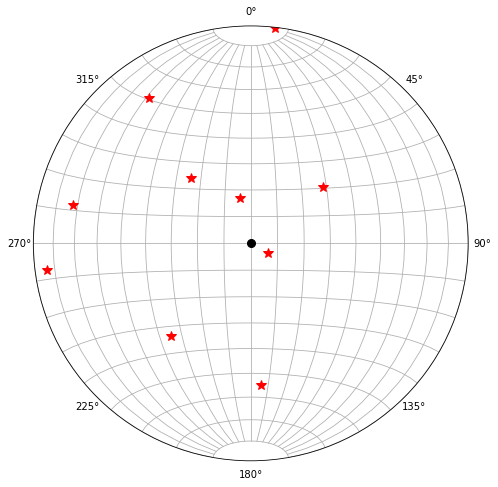

#1


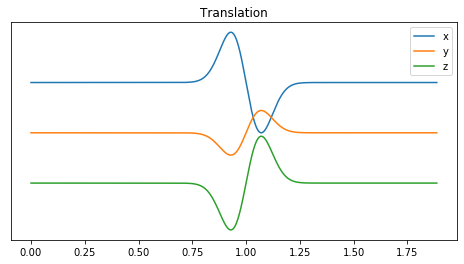

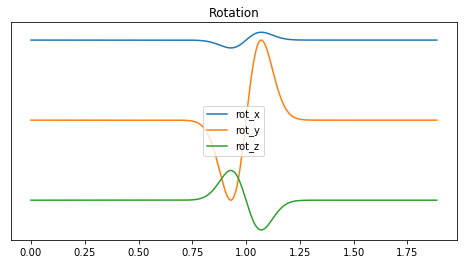

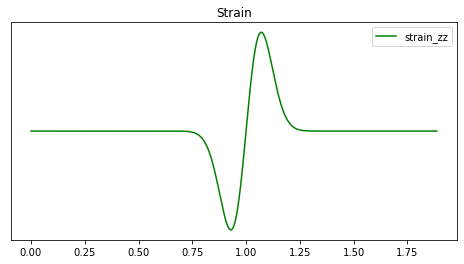

Accurate Propagation direction:
[-0.93263258  0.20232394  0.29876664]
Estimated:
[-0.93263258  0.20232394  0.29876664]
Angular Error:
0.0
#2
Accurate Propagation direction:
[0.44643227 0.35080317 0.82318611]
Estimated:
[0.44643227 0.35080317 0.82318611]
Angular Error:
0.0


C:\Users\sebi\Anaconda3\envs\obspy\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in arccos


#3
Accurate Propagation direction:
[0.11285514 0.99360034 0.00469998]
Estimated:
[0.11285514 0.99360034 0.00469998]
Angular Error:
nan
#4
Accurate Propagation direction:
[-0.37026592  0.40435763  0.83630022]
Estimated:
[-0.37026592  0.40435763  0.83630022]
Angular Error:
0.0
#5
Accurate Propagation direction:
[-0.07173971  0.2947352   0.95288225]
Estimated:
[-0.07173971  0.2947352   0.95288225]
Angular Error:
8.537736462515939e-07
#6
Accurate Propagation direction:
[-0.53914566  0.77227256  0.33603131]
Estimated:
[-0.53914566  0.77227256  0.33603131]
Angular Error:
0.0
#7
Accurate Propagation direction:
[-0.9859823  -0.13085759  0.10351424]
Estimated:
[-0.9859823  -0.13085759  0.10351424]
Angular Error:
8.537736462515939e-07
#8
Accurate Propagation direction:
[-0.47413085 -0.55161733  0.68623484]
Estimated:
[-0.47413085 -0.55161733  0.68623484]
Angular Error:
0.0
#9
Accurate Propagation direction:
[ 0.11450933 -0.06201832  0.99148441]
Estimated:
[ 0.11450933 -0.06201832  0.99148441]
An

In [6]:
f = 10.
N = 10
wavetype = 'qP' #'qP','qS1','qS2'

nus, gammas = get_direction('random',C,N)
plot_directions(nus)
for i in range(0,len(nus)):
    vel, v = get_eigenvals(gammas[i], density)
    seis, t = get_seis_one_wavetype(wavetype,v,vel,nus[i],f)
    
    n,_,_ = get_polarizations(seis)
    
    it = np.argmax(seis[6,:])
    rx = seis[3,it]
    ry = seis[4,it]
    ezz = seis[6,it]
    
    nu_e = np.zeros(3) 
    nu_e[2] = 1.
    nu_e[1] = 2*rx/ezz + n[1]/n[2]
    nu_e[0] = -2*ry/ezz + n[0]/n[2]

    l = 0
    for j in range(0,3):
        l += nu_e[j]**2
    nu_e = nu_e / np.sqrt(l)
    
    e = 0
    for j in range(0,3):
        e += nu_e[j]*nus[i][j]
    e = np.arccos(e)*180/np.pi    
    
    print('#'+str(i+1))
    if i==0:
        plot_7C(seis,t)
    print('Accurate Propagation direction:')
    print(nus[i])    
    print('Estimated:')
    print(nu_e)
    print('Angular Error:')    
    print(e)
    